# Classification Models

This file shows answers for Worksheet2 exercises. Much of the material in Worksheet2 is not here.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from df_after_transform import df_after_transform
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 50, "display.max_columns", None
)

import warnings
warnings.filterwarnings('ignore') 

## Load data 

In [2]:
loans = pd.read_csv('inputs/2013_subsample.zip')

## Create the training and holdout samples

Here, we will use `test_train_split`, though this might not 

In [3]:
# first let's separate y from X (as is typically done)
y = loans.loan_status == "Charged Off"
y.value_counts()
loans = loans.drop("loan_status", axis=1)

# stratify will make sure that test/train both have equal fractions of outcome
X_train, X_test, y_train, y_test = train_test_split(
    loans, y, stratify=y, test_size=0.2, random_state=0
)

## Setting up _one_ classification model

_Note: `preproc_pipe` is the exact same as last time, but I've defined it in a different (easier?) way, and I've named the whole pipeline `clf_logit`_

In [4]:
# set up pipeline to clean each type of variable (1 pipe per var type)

numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipe = make_pipeline(OneHotEncoder(drop="first"))

# combine those (make_column_transformer is like make_pipeline, maybe easier on the eyes!)

preproc_pipe = make_column_transformer(
    (numer_pipe, ["annual_inc", "int_rate"]),
    (cat_pipe, ["grade"]),
    remainder="drop",
)

# estimator

clf_logit = make_pipeline(preproc_pipe, LogisticRegression())

I'm going to fit it to the whole training dataset. This means what we're about to learn is being done without CV for now, and will likely result in overconfident performance metrics.

## Confusion Matrix for the baseline model ("M1")


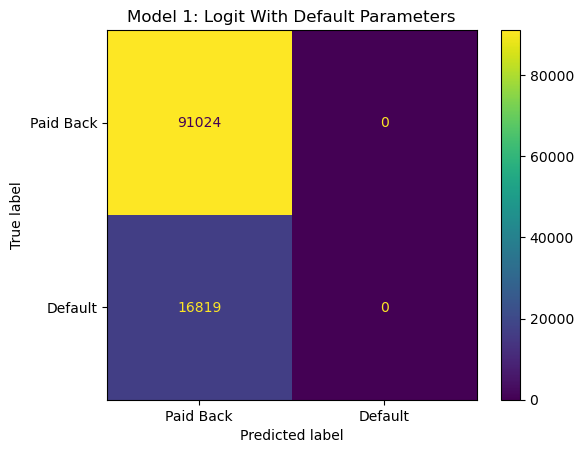

In [5]:
clf_logit.fit(X_train, y_train) 
ConfusionMatrixDisplay.from_estimator(
    clf_logit, 
    X_train, 
    y_train, 
    display_labels=["Paid Back", "Default"]
)
plt.title('Model 1: Logit With Default Parameters')
plt.show()

## Confusion Matrix for the upgrades model ("M2")

The issue that is causing this problem is something that is rampant in real business settings: **"Imbalanced classes."**

Meaning: We have 85% and 15% for our two classes (paid off and charged off) instead of 50/50.

Imbalance causes problems with many (though not all) ML estimators.

Denying a loan to a good customer is not as bad as giving a loan to a bad customer that defaults. You should probably _weigh_ defaults more heavily.

The `LogisticRegression()` model has a parameter that lets you decide how you weigh the class's importance. You can manually specify it, but `LogisticRegression(class_weight='balanced')` will cause the minority class to be considered equally important overall. (Maybe you want to weigh even more, which you can do by manually setting the weights.)

So, I'm going to change the pipeline to use that parameter:


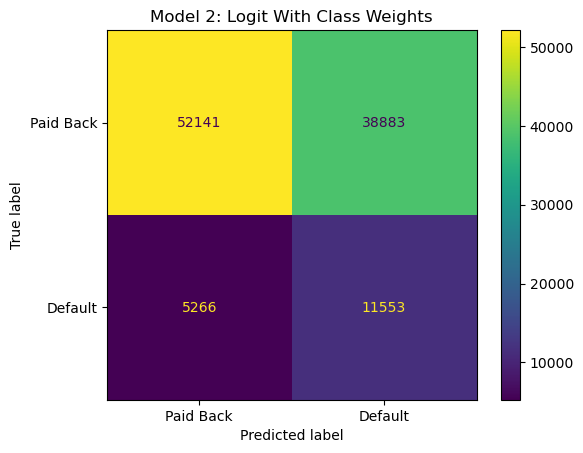

In [6]:
clf_logit.set_params(logisticregression__class_weight='balanced')
clf_logit.fit(X_train, y_train) 
ConfusionMatrixDisplay.from_estimator(
    clf_logit, 
    X_train, 
    y_train, 
    display_labels=["Paid Back", "Default"]
)
plt.title('Model 2: Logit With Class Weights')
plt.show()


## Exercises 1-5

For these questions, assume your bank uses automated underwriting: If the model says you'll pay back the loan, they make the loan. 

Make extra (reasonable) assumptions as needed to compare the two models:
1. How much money does M2 save us relative to M1 from reduced charge-offs?
2. How much foregone profit does M2 have relative to M1?
3. Would you rather use M1 or M2 at your bank and why?
4. Write down a profit function for firm. Use the cells of the confusion matrix as variables, as needed. 
    - The four cells of the matrix are TN (upper left), FP (upper right), TP (lower right), FN (lower left)
5. We want to maximize profits, but all the ML diagnostics above are different. Try to rewrite your profit function to include 

In [7]:
# put answers here

---

See: Board plan for lecture 23. 

_It helps to draw out the 2x2 confusion matrix grid 3 times:_
1. TN, FP, FN, TP. Add "lend" and no lend" to columns, "would pay back" and "would default" to rows. Add "paid back" to cell 1, "Forgone profit" to cell 2, "default/loss" to cell 3, "correctly avoid" to cell 4.
2. M1 amounts in each cell.
3. M2 amounts in each cell.

---

### Answers to 1-5

- Q1: Model 1 had 17k defaults, Model 2 has 5k.
    - savings of M2 = 12,000*(Loss on avg charge off)
    - savings of M2 = 12,000*(Avg Loan Size * Haircut on defaults)
- Q2 - M1 has no forgone profitable loans, M2 has 39k!
    - lost profit for M2 = 39,000*(Avg Loan size * Profit rate per dollar of loan)
    - Chase's ROA on loans is ~1%
- Q3: M2 > M1 if 
    - 12 x haircut > 0.39
    - haircut > 3.25%
    - _**First** lien loans in 2020: Avg haircut of 33%, median of 20%, per Fitch!_
    - M2 is much better for a lender to use!
- Q4: 

$$ Profit = (TN*ROA - FN*HaircutRate)*AvgLoanSize $$

- Q5: Ask students how we can rewrite this formula to incorporate precision, recall, or F1. The possible answers are below, and **all show that simply maximizing any of them won't get you profit maximization.**


We can rewrite that formula several ways to get precision or recall to show up.

---

Precision: If we multiply profit by $(TN+FN)/(TN+FN)$, we get

$$ = \left(\frac{TN}{(TN+FN)}*ROA - \frac{FN}{(TN+FN)}*H\right)*(AvgLoanSize*(TN+FN)) $$

Renaming things makes this

$$ = \left[Precision_0*ROA - \left(1-Precision_0\right)*H\right]*AvgLoanSize*\#Loans $$

Collecting terms, we have

$$ = \left(Precision_0*(ROA + Haircut) - H\right)*AvgLoanSize*\#Loans $$

This shows that, **all else equal**, if you _increase precision on loans given_, profit rises because a higher fraction of dollars loaned get the positive ROA and avoid the haircut (which is the economics behind the "+" in the last formula).

HOWEVER, a classifier/decision rule with very high precision is not likely to maximize profits because as the decision rule threshold increases (which increases precision and the fraction of paid back loans), the number of times you'll make the decision to lend falls, and this lowers profits. 

---

Recall: If we multiply profit by $(TN+FP)/(TN+FP)$, we get

$$ = \left(\frac{TN}{(TN+FP)}*ROA - \frac{FN}{(TN+FP)}*H\right)*(AvgLoanSize*(TN+FP)) $$

Renaming things makes this

$$ = \left[Recall_0*ROA - \frac{FN}{(TN+FP)}*H\right]*AvgLoanSize*\#Loans $$

That second term is messy. If we multiple it by (TN+FN)/(TN+FN):

$$ = \left[Recall_0*ROA - \frac{FN}{(TN+FN)}\frac{(TN+FN)}{(TN+FP)}*H\right]*AvgLoanSize*\#Loans $$

$$ = \left[Recall_0*ROA - (1-Precision_0)\frac{\#LoansMade}{(\#True=0)}*H\right]*AvgLoanSize*\#Loans $$

So we can try to maximize _recall_ of loans paid back. But this means we will choose a lowew precision rule, because recall and precision are inversely related. And the math above shows that precision is positively related to profit (which the last version showed as well).

So the optimal threshold in terms of recall might not maximize profits.

## How about we just... maximize profits? 

First, let's work on getting SKLEARN to output the score of our models as profits. 



## Evaluating the models with a custom objective function (Exercise 6)

For classification problems, online ML contests tell competitors to maximize some criterion. This is often AUC or F1, which are well understood metrics that are easy to obtain from any ML package. However, your bosses don't care about these metrics per se: Your firm (a lender in this case) lender is _**profit**_ maximizing. 

So: Let's evaluate how our models do in generating profit. 

In [8]:
# define the profit function

def custom_prof_score(y, y_pred, roa=0.02, haircut=0.20):
    '''
    Firm profit is this times the average loan size. We can
    ignore that term for the purposes of maximization. 
    '''
    TN = sum((y_pred==0) & (y==0)) # count loans made and actually paid back
    FN = sum((y_pred==0) & (y==1)) # count loans made and actually defaulting
    return TN*roa - FN*haircut

# so that we can use the fcn in sklearn, "make a scorer" out of that function

from sklearn.metrics import make_scorer
prof_score = make_scorer(custom_prof_score)

M1: Our pipeline with imbalanced classes:

In [9]:
clf_logit1 = make_pipeline(preproc_pipe, LogisticRegression())

scores1 = cross_validate(clf_logit1,
                        X_train, y_train,
                        scoring=prof_score)

scores1['test_score'].mean().round(3)

-308.664

M2: Our pipeline with balanced classes:


In [10]:
clf_logit2  = make_pipeline(preproc_pipe, 
                           LogisticRegression(class_weight='balanced'))

scores2 = cross_validate(clf_logit2,
                        X_train, y_train,
                        scoring=prof_score)

scores2['test_score'].mean().round(3)

-2.016

This is a HUGE improvement! Hopefully we can get into the black with some changes.

### Exercise 6, M3

Weigh not by *number* of loans approved or denied. 

Weigh by the profit associated with pay back/denial.

Loans paid back generate a profit of 2% each. 

Charge offs cost us 20% each. 

This means charge offs aren't equally important to paid off loans: they are 10x more important!

In [11]:
clf_logit3  = make_pipeline(preproc_pipe, 
                           LogisticRegression(class_weight={0: 0.02, 1: 0.2}))

scores3 = cross_validate(clf_logit3,
                        X_train, y_train,
                        scoring=prof_score)

scores3['test_score'].mean().round(3)

34.308

OMG!

In [12]:
clf_logit3.fit(X_train, y_train) 
print(classification_report(y_train, clf_logit3.predict(X_train)))

              precision    recall  f1-score   support

       False       0.94      0.27      0.42     91024
        True       0.19      0.90      0.31     16819

    accuracy                           0.37    107843
   macro avg       0.56      0.59      0.37    107843
weighted avg       0.82      0.37      0.41    107843



## Exercise 7: Optimize profit immediately

Above, we tried 3 weighting schemes (default, balanced, econ-weighted) that changed how much the logistic estimation cared about certain observations when it estimated its coefficient parameters. 

We evaluated the resulting classifiers in terms of profit. 

But the logits weren't optimized for profit. They just solve the problem of trying to predict probabilities, as worksheet 2 said:

> [Classification is best divided into two parts:](https://scikit-learn.org/stable/modules/classification_threshold.html#)
> 1. the statistical problem of learning a model to predict, ideally, class probabilities;
> 2. the decision problem to take concrete action based on those probability predictions.

But we never optimized the second part of the classification problem: the thresholds for the classifier are just 0.5. Maybe that's not optimal.

Let's do that. The most direct way: Plot profit as a function of the threshold.

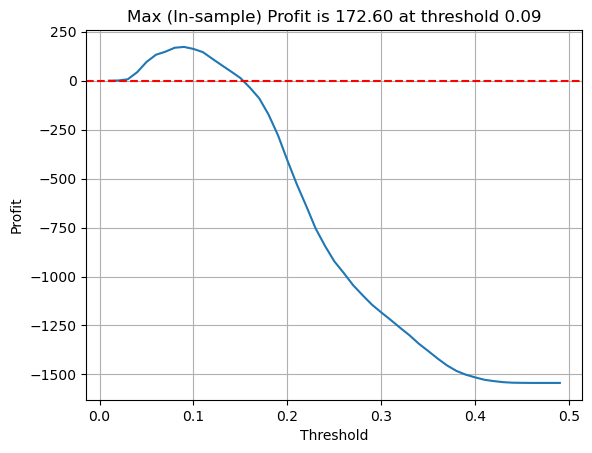

In [13]:
# BANKS MAXIMIZE PROFIT
clf_logit1.fit(X_train, y_train)
y_prob = clf_logit1.predict_proba(X_train)[:, 1]

# Calculate profit at different thresholds
thresholds = np.arange(0.01, 0.5, 0.01)
profit = [custom_prof_score(y_train, (y_prob >= threshold)) for threshold in thresholds]

plt.plot(thresholds, profit)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title(f'Max (In-sample) Profit is {max(profit):.2f} at threshold {thresholds[np.argmax(profit)]:.2f}')
plt.grid()
plt.show()

## Exercise 7 bonus 1: Automatically getting the threshold decision made for you

That loop is simple to execute but worked on all of the data we gave it. 

We could pick the threshold with CV too, to avoid overfitting on the threshold!

`TunedThresholdClassifierCV` does it, and it works just like the `cross_validate` function. 

In [14]:
from sklearn.model_selection import TunedThresholdClassifierCV

model = TunedThresholdClassifierCV(clf_logit1, scoring=prof_score, cv=5)  # you put your pipeline in here
model.fit(X_train, y_train)

print(f''' 
The best threshold is:        {model.best_threshold_:.4f}
In sample profits are:        {custom_prof_score(y_train, model.predict(X_train)):.2f}
''') # Out of sample is 4* because of 4x sample size in training, I adjusted here so scale is same


 
The best threshold is:        0.0923
In sample profits are:        170.00



## Exercise 7 bonus 2: Automatically getting the threshold decision made for you INSIDE A PIPELINE


In [15]:
pipe_with_threshold_choice = make_pipeline(preproc_pipe, 
                                           TunedThresholdClassifierCV(LogisticRegression(), scoring=prof_score, cv=5))
                                           
pipe_with_threshold_choice.fit(X_train, y_train)

print(f''' 
The best threshold is:        {pipe_with_threshold_choice['tunedthresholdclassifiercv'].best_threshold_:.4f}
In sample profits are:        {custom_prof_score(y_train, pipe_with_threshold_choice.predict(X_train)):.2f}
''') # Out of sample is 4* because of 4x sample size in training, I adjusted here so scale is same


 
The best threshold is:        0.0924
In sample profits are:        170.42



## Experimental code section - Students should ignore all this.

I don't even know if it's right or smart to do!

That threshold finder doesn't work *within* a CV fold. It uses all of X_train, and uses folds of that to pick the threshold.

So I (a robot) made a way to do threshold tuning inside CV folds. This is a decent first hack.

It's pretty simple to use: You still use cross_validate with your scoring choice and pipeline, it's just that your pipeline ends with `ThresholdOptimizer(LogisticRegression(), scoring_function=custom_prof_score)` instead of `LogisticRegression()`.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

class ThresholdOptimizer(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, scoring_function):
        self.base_estimator = base_estimator
        self.scoring_function = scoring_function
        self.threshold_ = 0.5  # default, will be updated in fit

    def fit(self, X, y):
        self.model_ = clone(self.base_estimator)
        self.model_.fit(X, y)

        # Use validation to find the best threshold
        probs = self.model_.predict_proba(X)[:, 1]
        thresholds = np.linspace(0.01, 0.99, 99)
        best_score = -np.inf

        for t in thresholds:
            preds = (probs >= t).astype(int)
            # Handle different types of scoring functions
            if hasattr(self.scoring_function, '_score_func'):
                # For sklearn scorers
                score_func = self.scoring_function._score_func
                score = score_func(y, preds)
            elif callable(self.scoring_function):
                # For direct function calls
                score = self.scoring_function(y, preds)
            else:
                raise ValueError("scoring_function must be callable or a sklearn scorer")
                
            if score > best_score:
                best_score = score
                self.threshold_ = t

        return self

    def predict(self, X):
        probs = self.model_.predict_proba(X)[:, 1]
        return (probs >= self.threshold_).astype(int)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

    def get_params(self, deep=True):
        params = {
            "base_estimator": clone(self.base_estimator) if deep else self.base_estimator,
            "scoring_function": self.scoring_function
        }
        return params

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


Now, 

In [ ]:

# This means logit is run and the decision threshold is optimized after it immediately 
logit_with_threshold = ThresholdOptimizer(
    LogisticRegression(), 
    scoring_function=custom_prof_score
)

# Create the pipeline like normal, just use the special logit estimator 
clf_logit4 = Pipeline([
    ('preprocessing', preproc_pipe), 
    ('threshold_classifier', logit_with_threshold)
])

# Run cross-validation like normal
cv_results = cross_validate(
    clf_logit4, 
    X_train, 
    y_train, 
    scoring=prof_scorer,  # Use the scorer here
    cv=5, 
    return_train_score=True # Optional
)


In [ ]:
cv_results